# 5. Selección de Modelos

In [1]:
import numpy as np

## Dataset

Definimos datos de lenguaje natural de juguete y vectorizamos el input usando bolsas de palabras.

In [2]:
training = [
    ('chinese beijing chinese', 'zh'),
    ('chinese chinese shangai', 'zh'),
    ('chinese macao', 'zh'),
    ('chinese beijing tokyo', 'zh'),
    ('chinese beijing osaka', 'zh'),
    ('tokyo japan chinese', 'ja'),
    ('tokyo japan osaka', 'ja'),
    ('osaka', 'ja'),
]

In [3]:
X_docs = np.array([doc for doc, _ in training])
y = np.array([cls for _, cls in training])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X = vect.fit_transform(X_docs)

In [5]:
X

<8x7 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

## Validación Cruzada

- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

### División K-Fold

Podemos usar [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) para hacer cross-validation:

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=False, random_state=0)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(f"TRAIN: {train_index} VAL: {val_index} {y_val}")

    #model.fit(X_train, y_train)
    #model.predict(X_val)

TRAIN: [2 3 4 5 6 7] VAL: [0 1] ['zh' 'zh']
TRAIN: [0 1 4 5 6 7] VAL: [2 3] ['zh' 'zh']
TRAIN: [0 1 2 3 6 7] VAL: [4 5] ['zh' 'ja']
TRAIN: [0 1 2 3 4 5] VAL: [6 7] ['ja' 'ja']


/Users/pgianni/venv/diplo/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


### División K-Fold Estratificada

Para que la división sea estratificada, usamos [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html):

In [7]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3, shuffle=False, random_state=0)

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(f"TRAIN: {train_index} VAL: {val_index} {y_val}")

    #model.fit(X_train, y_train)
    #model.predict(X_val)

TRAIN: [2 3 4 6 7] VAL: [0 1 5] ['zh' 'zh' 'ja']
TRAIN: [0 1 4 5 7] VAL: [2 3 6] ['zh' 'zh' 'ja']
TRAIN: [0 1 2 3 5 6] VAL: [4 7] ['zh' 'ja']


## Búsqueda en Grilla (Grid Search)

- [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

### Grilla de Parámetros

In [9]:
from sklearn.tree import DecisionTreeClassifier
# DecisionTreeClassifier??

In [10]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2],
}

Podemos listar todas las combinaciones para usarlas a mano con [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html):

In [11]:
from sklearn.model_selection import ParameterGrid

for params in ParameterGrid(param_grid):
    print(params)
    model = DecisionTreeClassifier(**params, random_state=0)
    #model.fit(...)
    #model.predict(...)

{'criterion': 'gini', 'max_depth': 1}
{'criterion': 'gini', 'max_depth': 2}
{'criterion': 'entropy', 'max_depth': 1}
{'criterion': 'entropy', 'max_depth': 2}


### Grilla de Parámetros + Validación Cruzada

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) nos sirve para hacer validación cruzada sobre una grilla de parámetros. Sklearn se encarga de todo el proceso y nos devuelve una tabla de resultados y el mejor clasificador obtenido.

La búsqueda se puede configurar de varias maneras. Por defecto la validación cruzada es estratificada.

- [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter9)

In [12]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state=0)

cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
cv.fit(X, y);

In [13]:
results = cv.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

print("crit.\tdepth\t| mean\tstd\trank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")

crit.	depth	| mean	std	rank
gini	1	| 0.50	0.14	3
gini	2	| 0.61	0.08	1
entropy	1	| 0.50	0.14	3
entropy	2	| 0.61	0.08	1


In [14]:
import pandas as pd
df = pd.DataFrame(results)
df[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_criterion,param_max_depth,mean_test_score,std_test_score,rank_test_score
0,gini,1,0.500000,0.136083,3
1,gini,2,0.611111,0.078567,1
2,entropy,1,0.500000,0.136083,3
3,entropy,2,0.611111,0.078567,1


In [15]:
best_model = cv.best_estimator_

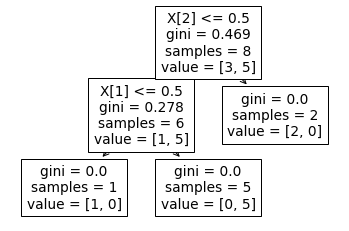

In [16]:
from sklearn.tree import plot_tree

plot_tree(best_model);

### Grilla Aleatorizada

- [Randomized Parameter Optimization](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)

In [17]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(random_state=0)

In [18]:
#from sklearn.utils.fixes import loguniform
from scipy import stats

param_dist = {
    'loss': [
        'hinge',        # SVM
        'log',          # logistic regression
        #'preceptron',  # perceptron (not supported)
    ],
    'alpha': stats.loguniform(1e-4, 1e0),
}

Podemos muestrear mano con [ParameterSampler](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html):

In [19]:
from sklearn.model_selection import ParameterSampler

for params in ParameterSampler(param_dist, 4, random_state=0):
    print(params)
    model = SGDClassifier(**params, random_state=0)
    #model.fit(...)

{'alpha': 0.01567667719550606, 'loss': 'log'}
{'alpha': 0.23826650493636625, 'loss': 'log'}
{'alpha': 0.015119336467640998, 'loss': 'log'}
{'alpha': 0.031207198770106415, 'loss': 'hinge'}


### Grilla Aleatorizada + Validación Cruzada

También podemos dejar que Sklearn se encargue de todo con [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):


In [20]:
from sklearn.model_selection import RandomizedSearchCV

model = SGDClassifier(random_state=0)

cv = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3)
cv.fit(X, y);

In [21]:
import pandas as pd
results = cv.cv_results_
df = pd.DataFrame(results)
df[['param_alpha', 'param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_alpha,param_alpha,mean_test_score,std_test_score,rank_test_score
0,0.0136015,0.0136015,0.888889,0.157135,1
1,0.00867446,0.00867446,0.888889,0.157135,1
2,0.000669893,0.000669893,0.888889,0.157135,1
3,0.000853172,0.000853172,0.888889,0.157135,1
4,0.00380612,0.00380612,0.888889,0.157135,1
5,0.00410007,0.00410007,0.888889,0.157135,1
6,0.00564245,0.00564245,0.888889,0.157135,1
7,0.000412041,0.000412041,0.888889,0.157135,1
8,0.0458784,0.0458784,0.888889,0.157135,1
9,0.0003964,0.0003964,0.888889,0.157135,1
